# PROJECT: Course Optimization for Data Science
## Optimization strategies for (Rank-)Support Vector Machines (SVM)

Authors: Alexandre Gramfort, Robert Gower

If you have questions or if something is not clear in the text below please contact us
by email.

## Aim:

- derive the duals for SVMs for binary classification with and without intercept
- implement an SVM using a blackbox convex toolbox (cvxopt in Python)
- implement your own solvers for the "without intercept" case: Proximal gradient, Coordinate Descent, Newton, Quasi-Newton
- use these solvers to tackle the SVM-rank ML problem
- present a clear benchmark of the different strategies on small and medium scale datasets
- test your code on real data!


## VERY IMPORTANT

This work must be done by pairs of students.
Each student must send their work before the 17th of January 2021 at 23:59, using the moodle platform.
This means that **each student in the pair sends the same file**

On the moodle, in the "Optimization for Data Science" course, you have a "devoir" section called "Project".
This is where you submit your jupyter notebook file.

The name of the file must be constructed as in the next cell

### Gentle reminder: no evaluation if you don't respect this EXACTLY

#### How to construct the name of your file

In [1]:
# Change here using YOUR first and last names
fn1 = "huang"
ln1 = "kaixian"
fn2 = "bai"
ln2 = "yuhe"

filename = "_".join(map(lambda s: s.strip().lower(), 
                        ["project", ln1, fn1, "and", ln2, fn2])) + ".ipynb"
print(filename)

project_kaixian_huang_and_yuhe_bai.ipynb


Some imports

In [2]:
%matplotlib inline
import numpy as np
from scipy import linalg
import time
import matplotlib.pyplot as plt

## Important:

For Part 0 to Part 2 of the project you will need a working install of `cvxopt`.
You may struggle a bit to set it up.
The simplest way of getting it is by typing 

`conda install -c conda-forge cvxopt`

(if you're using conda)

or

`pip install cvxopt`

See https://cvxopt.org/install/ for instructions.

If you **struggle too much please contact us**. Don't waste time with this!

<div class="alert alert-info">
    <h2>Part 0: SVM Classification with linear kernel</h2>
</div>

Let us consider the problem of binary classification from $n$ observations
$x_i \in \mathbb{R}^{d}$,
$1 \leq i \leq n$. We aim to learn a function:
$$f: x \in \mathbb{R}^{d}\mapsto y\in\{-1,+1\}$$
from the $n$ annotated training samples $(x_{i},y_{i})$ supposed i.i.d. from an unknown probability distribution on $\mathbb{R}^d \times \{-1,+1\}$. Once this function is learnt, it will be possible to use it to predict the label $y$ associated to a new sample $x$.

Margin and linear separating hyperplane:

<img src="separateur.png">

In the linear case, one looks for an affine function of $x$ of the form 
$f(x) = \mathrm{sign}(w^{\top} x)$ or $f(x)=\mathrm{sign}(w^{\top}x + b)$
with $w \in \mathbb{R}^d$ and $b \in \mathbb{R}$. The first case is referred
to as the **without intercept** case. Indeed the coefficient $b$ is known
as the intercept or bias term.

We will start by considering the case with intercept.

To learn $f$, we use the $n$ annotated samples and one looks for a hyperplane $P(w,b)$
such that the smallest distance to positive and negative samples
is the largest. This can be written as:
$$
 \max_{w,b} \min_{i=1:n} y_i \delta(x_{i},P(w,b)) \quad
 \text{where}\quad \delta(x_{i},w,b) = \frac{w^{\top}x_{i}+b}{\sqrt{w^{\top}w}} \enspace,
$$
since the signed distance from a sample $x_{i}$ to the hyperplane $P(w,b)$ is given by
$
\delta(x_{i},w,b)
$.
The principle described above is the maximisation of the *margin*.

One can notice that if the minimum of a set of values is larger than $m$ than all values of the set are larger than $m$. This leads to the following problem formulation:
$$
 \left\{
 \begin{array}{cll}
 \max_{(w,b)} \quad m \\
 \text{s.t.} \;\; &\forall i &y_i\dfrac{w^{\top}x_{i}+b}{\sqrt{w^{\top}w}}\geq m
 \end{array}
 \right. \enspace .
$$

The hyperplane separates the space in 2 half spaces, depending if $\delta(x_{i},w,b)$ is positive or negative.

Assuming all samples are linearly separable, convince yourself that the problem can be written as:
$$
(\mathcal{P}):  \left\{
 \begin{array}{cll}
 &\min_{(w,b)} \frac{1}{2}w^{\top}w
 \\
  &y_{i}(w^{\top}x_{i}+b)\geq 1, \quad \forall i\in \{1,\cdots,n\}
 \end{array}
 \right.
$$

<div class="alert alert-success">
    <b>QUESTION 1:</b>
     <ul>
       <li>Justify that the problem $(\mathcal{P})$ is convex.</li>
    </ul>
</div>

<div class="alert alert-warning">
<b>ANSWER QUESTION 1:</b>
    
<b>Definition(Convex problem):</b> 
    A convex optimization problem is a problem where all of the constraints are convex functions, and the objective is a convex function if minimizing.
    <ul>
    <li>Since $\min_{(w,b)} \frac{1}{2}w^{\top}w$ is a quadratic function, so it is convex.
        <li> Since the constraints of $1 - y_{i}(w^{\top}x_{i}+b)\leq 0, \quad \forall i\in \{1,\cdots,n\}$ are all linear constraints, so it is convex.
            <li>Therefore, the problem $(\mathcal{P})$ is convex.
    </ul>
    </div>

<div class="alert alert-success">
    <b>QUESTION 2:</b>
     <ul>
       <li>By looking at the saddle points of the Lagrangian $\mathcal{L}(w, b, \mu)$, $\mu \in \mathbb{R}_+^n$, show that the dual problem $(\mathcal{D})$ can be written as:</li>
    </ul>

$$
(\mathcal{D}): 
 \left\{
 \begin{array}{lll}
 \min_{\mu} &\frac{1}{2}\mu^{\top}GG^{t}\mu-\mu^{\top}u
 \\
 \mathrm{s.c.}& y^{\top}\mu = 0
 \\
 \mathrm{and}& -\mu \leq  0
 \end{array}
 \right .
$$

with

$$
 G = \begin{bmatrix}y_{1}x_{1}^{\top} \\ \vdots \\ y_{n}x_{n}^{\top}\end{bmatrix}
$$

and $u = (1, \dots, 1) \in \mathbb{R}^n$.

Remark: We will **assume here qualification of the contraints**.

Remark: The problem $(\mathcal{D})$ is a *quadratic program* (QP) for which their exist off-the-shelf techniques. See below.
</div>

<div class="alert alert-warning">
<b>ANSWER QUESTION 2:</b>
    

The lagrange of (P):
    
$$\mathcal{L}(w, b, \mu) = \frac{1}{2}w^{\top}w + \sum_{i=1}^{n} \mu_i(1 - y_{i}(w^{\top}x_{i}+b))$$
    
The Dual problem (D):
    
$$\max_{\mu} \min_{w,b} \mathcal{L}(w,b,\mu)$$

According to KKT condition:

$$
 \left\{
 \begin{array}{cll}
 \nabla w \mathcal{L}(w,b, \mu) = 0\\
 \mu_i > 0, i=1,...,n\\
 \nabla b \mathcal{L}(w,b, \mu) = 0
 \end{array}
 \right. 
 \Longrightarrow
 \left\{
 \begin{array}{cll}
 w + \sum_{i=1}^{n} \mu_i y_i x_i = 0\\
 \mu_i > 0, i=1,...,n\\
 \sum_{i=1}^{n} \mu_i y_i = 0
 \end{array}
 \right. 
$$
    
So (D) can be written as follows:
$$\max_{\mu > 0, y^T\mu=0} \frac{1}{2}(\sum_{i=1}^{n} \mu_i y_i x_i)^T (\sum_{i=1}^{n} \mu_i y_i x_i) + \sum_{i=1}^{n} \mu_i -\sum_{i=1}^{n} \mu_i y_i x_i^T(\sum_{j=1}^{n} \mu_j y_j x_j) - \sum_{j=1}^{n}u_iy_ib$$
    
$$= \max_{\mu > 0, y^T\mu=0} -\frac{1}{2}\sum_{i=1}^{n}\sum_{j=1}^{n}\mu_i\mu_jy_iy_jx_i^Tx_j + \sum_{i=1}^{n}\mu_i$$
    
$$= \min_{\mu > 0, y^T\mu=0} \frac{1}{2}\sum_{i=1}^{n}\sum_{j=1}^{n}\mu_i\mu_jy_iy_jx_i^Tx_j - \sum_{i=1}^{n}\mu_i$$
    
$$\Longleftrightarrow \left\{
 \begin{array}{cll}
 \min\frac{1}{2}(\mu_1,\mu_2,...,\mu_n)\begin{pmatrix}
 x_1^Tx_1y_1y_1 &x_1^Tx_2y_1y_2 & \cdots \\
 \vdots & \vdots & \vdots\\
 x_n^Tx_1y_ny_1 & \cdots & x_n^Tx_ny_ny_n
 \end{pmatrix}
 \begin{pmatrix}u_1\\u_2\\\vdots\\u_n
 \end{pmatrix}+\mu^Tu\\
 s.c.\quad y^{\top}\mu = 0\\
 -\mu \leq  0
 \end{array}
 \right. $$
    
where $u = (1, \dots, 1) \in \mathbb{R}^n.$
$$\Longleftrightarrow
(\mathcal{D}): 
 \left\{
 \begin{array}{lll}
 \min_{\mu} &\frac{1}{2}\mu^{\top}GG^{t}\mu-\mu^{\top}u
 \\
 \mathrm{s.c.}& y^{\top}\mu = 0
 \\
 \mathrm{and}& -\mu \leq  0
 \end{array}
 \right .
$$
</div>

<div class="alert alert-success">
    <b>QUESTION 3:</b>
     <ul>
       <li>Justify that given the estimated $\mu$, the prediction function for a new sample $x$ is given by:</li>
    </ul>
    $$
y = \mathrm{sign}(\sum_{i=1}^{n} \mu_i y_i x_i^\top x + b) \enspace .
$$

The vector $w$ is therefore equal to $\sum_{i=1}^{n} \mu_i y_i x_i$
</div>

<div class="alert alert-warning">
<b>ANSWER QUESTION 3:</b>
    
We know the estimated $\mu$ and new sample x
    
According to Q2:
$$w = \sum_{i=1}^{n}\mu_iy_ix_i$$
$$y = \mathrm{sign}(w^Tx + b) =\mathrm{sign}((\sum_{i=1}^{n} \mu_i y_i x_i^\top) x + b) \enspace .$$
    
    
</div>

<div class="alert alert-info">
    <h2>Part 1: Implementation of solver with intercept using cvxopt</h2>
</div>

The file svm_project_utils.py contains the code to generate some toy data and plot them

In [3]:
from svm_project_utils import plot_dataset, datasets

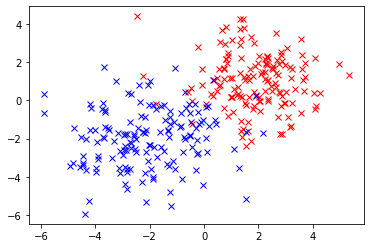

In [4]:
X, y = datasets(name='gaussian', n_points=300)
plot_dataset(X, y)

- The following function qp allows to solve a quadratic problem of the form:

$$
\left\{
  \begin{array}{cll}
  &\min_{(x)} \frac{1}{2}x^{\top} H x - e^\top x
  \\
   & \textrm{s.c.}\; A^\top x = b, 0 \leq x \leq C.
  \end{array}
  \right.
$$

In [5]:
import cvxopt


def qp(H, e, A, b, C=np.inf, l=1e-8, verbose=True):
    # Gram matrix
    n = H.shape[0]
    H = cvxopt.matrix(H)
    A = cvxopt.matrix(y, (1, n))
    e = cvxopt.matrix(-e)
    b = cvxopt.matrix(0.0)
    if C == np.inf:
        G = cvxopt.matrix(np.diag(np.ones(n) * -1))
        h = cvxopt.matrix(np.zeros(n))
    else:
        G = cvxopt.matrix(np.concatenate([np.diag(np.ones(n) * -1),
                                         np.diag(np.ones(n))], axis=0))
        h = cvxopt.matrix(np.concatenate([np.zeros(n), C * np.ones(n)]))

    # Solve QP problem
    cvxopt.solvers.options['show_progress'] = verbose
    solution = cvxopt.solvers.qp(H, e, G, h, A, b)
 
    # Lagrange multipliers
    mu = np.ravel(solution['x'])
    return mu

Definition of the linear kernel:

In [6]:
def kernel(X1, X2):
    n1 = X1.shape[0]
    n2 = X2.shape[0]
    K = np.empty((n1, n2))
    for i in range(n1):
        for j in range(n2):
            K[i, j] = np.dot(X1[i], X2[j])
    return K

<div class="alert alert-success">
    <b>QUESTION 4:</b>
     <ul>
       <li>Modify the following cell to solve the SVM dual problem:</li>
    </ul>
</div>

Number of support vectors: 3


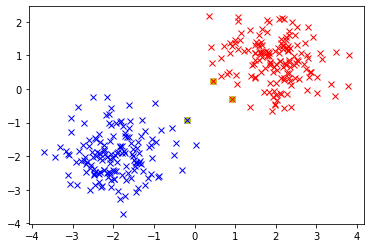

In [7]:
X, y = datasets(name='gaussian', n_points=300, sigma=0.7)
plot_dataset(X, y)

# TODO
def svm_solver(K, y, C=np.inf):
    H = ((y * K).T*y).T
    e = np.ones(y.shape[0])
    A = y
    b = 0
    mu = qp(H, e, A, b, C, l=1e-8, verbose=False)
    idx_support = np.where(np.abs(mu) > 1e-5)[0]
    mu_support = mu[idx_support]
    return mu_support, idx_support

K = kernel(X, X)
# Uncomment the following lines when your svm_solver is completed:
mu_support, idx_support = svm_solver(K, y)
print("Number of support vectors: %s" % idx_support.size)
plt.scatter(X[idx_support][:,0],X[idx_support][:,1],label="support", color='y')

<div class="alert alert-success">
    <b>QUESTION 5:</b>
     <ul>
       <li>Compute w from mu and b</li>
    </ul>
</div>

In [8]:
# TODO
w = np.sum((mu_support*y[idx_support]).reshape((-1,1))*X[idx_support],axis =0)
print("coefficient: %s" % w)

coefficient: [1.21509449 1.04211452]


<div class="alert alert-success">
    <b>QUESTION 6:</b>
     <ul>
       <li>Using complementary slackness, explain how to obtain $b$ from $\mu$.</li>
    </ul>
<br/>
    <b>Remark:</b> complementary slackness states that if $\mu_i$ is an optimal lagrange multiplier and $f_i$ is a constraint of the primal problem than $\mu_i f_i(x^*) = 0$, where x^* is here a primal optimal value (notations here do not match the SVM context).
<br/><br/>
    <b>HINT:</b> Use the fact that for all support vectors for which $\mu_i$ is non-zero one has $y_{i}(w^{t}x_{i}+b) = 1$.
<br/><br/>
    <b>HINT:</b> Have a look at <a href="https://web.stanford.edu/class/ee364a/lectures/duality.pdf">these slides</a> and chapter 5 in <a href="https://web.stanford.edu/~boyd/cvxbook/bv_cvxbook.pdf"> this book </a> for more information on convex duality.
</div>

<div class="alert alert-warning">
<b>ANSWER QUESTION 6:</b>
    
Because of the complementary slackness:
$$\mu_i(1-y_i(w^Tx_i+b))=0$$
And for all support vector(j) $\mu_j > 0$ else $\mu_j = 0$
$$1-y_jw^Tx_j = y_jb$$
    
if $y_i = 1, b=1-w^Tx_j$
    
else $y_i = -1, b=-1-w^Tx_j$
$$\Longrightarrow b=y_j-w^Tx_j \quad and \quad w=\sum_{i=1}^{n}\mu_iy_ix_i$$
    
$$b=y_j-\sum_{i=1}^{n}\mu_iy_ix_i^Tx_j$$
Where (j) is one of the support vector
    
</div>

In [9]:
# TODO

def compute_b(K, y, mu_support, idx_support):
    # TODO
    y_support = y[idx_support]
    K_support = K[idx_support][:, idx_support]
    b = y_support[0] - np.sum(mu_support * y_support * K_support[0,:])
    return b

b = compute_b(K, y, mu_support, idx_support)
print("b= %s"  % b)

b= 0.19257229493063532


<div class="alert alert-success">
    <b>QUESTION 7:</b>
     <ul>
       <li>Verify that the constraints of the primal problem are satistified up to an acceptable numerical precision. You should verify that for all $i$ we have:</li>
    </ul>
$$
y_{i}(w^{\top}x_{i}+b) \geq 1 - \epsilon
$$

using for example $\epsilon = 1e-5$.
</div>

In [10]:
# TODO
n = y.shape[0]
results = y *np.dot(X, w) + y*b - 1 + 1e-5
print("If the inequalities hold ? : %s" % np.all(results >= 0))

If the inequalities hold ? : True


Check your code by running the following cell:

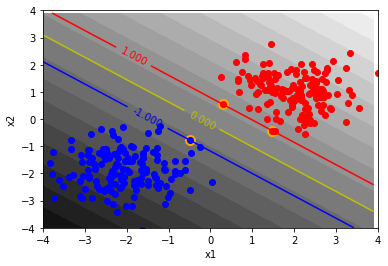

In [11]:
X, y = datasets(name='gaussian', n_points=300, sigma=0.7)

K = kernel(X, X)
mu_support, idx_support = svm_solver(K, y)
b = compute_b(K, y, mu_support, idx_support)

def plot_classif(X, y, mu_support, idx_support, b, kernel=kernel):
    # Calcul de la fonction de décision sur une grille
    X1, X2 = np.mgrid[-4:4:0.1, -4:4:0.1]
    na, nb = X1.shape
    X_test = np.c_[np.reshape(X1, (na * nb, 1)),
                   np.reshape(X2, (na * nb, 1))]

    # Calcul des produits scalaires
    X_support = X[idx_support]
    G = kernel(X_test, X_support)
    # Calcul de la fonction de décision
    decision = G.dot(mu_support * y[idx_support]) + b

    # Calcul du label prédit
    y_pred = np.sign(decision)

    # Affichage des lignes de niveau de la fonction de decision
    plt.contourf(X1, X2, np.reshape(decision, (na, nb)), 20, cmap=plt.cm.gray)
    cs = plt.contour(X1, X2, np.reshape(decision, (na,nb)), [-1, 0, 1], colors=['b', 'y', 'r'])
    plt.clabel(cs, inline=1)
    plt.plot(X[y == 1,0], X[y == 1, 1], 'or', linewidth=2)
    plt.plot(X[y == -1,0], X[y == -1, 1], 'ob', linewidth=2)
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.xlim([-4, 4])
    plt.ylim([-4, 4])

plot_classif(X, y, mu_support, idx_support, b)
plt.scatter(X[idx_support][:,0],X[idx_support][:,1],label="support", color = 'orange', s =100)

We will now change the value of $\sigma$ such that the problem is not linearly separable anymore.

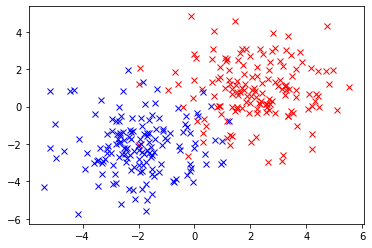

In [12]:
X, y = datasets(name='gaussian', n_points=300, sigma=1.5)
plot_dataset(X, y)

In [13]:
K = kernel(X, X)
mu_support, idx_support = svm_solver(K, y)
b = compute_b(K, y, mu_support, idx_support)
w = np.sum((mu_support * y[idx_support])[: , None] * X[idx_support], axis=0)

<div class="alert alert-success">
    <b>QUESTION 8:</b>
     <ul>
       <li>Check that constraints of the problem are now violated, can you explain what happened? How many are there according to the precision given in Question 7?</li>
    </ul>
</div>

<div class="alert alert-warning">
    <b>ANSWER QUESTION 8:</b>
    <ul>
    Because, there is no such a plane that can separate the datasset,which means the problem has no solution.
    </ul>
</div>

In [14]:
# TODO
n = y.shape[0]
results = y *np.dot(X, w) + y*b - 1 + 1e-5
print("If the inequalities hold ? : %s" % np.all(results >= 0))
print('The number of the wrong points: %d' % np.sum(results <= 0))

If the inequalities hold ? : False
The number of the wrong points: 166


### There is no such hyperplan can seperate the points, which means 

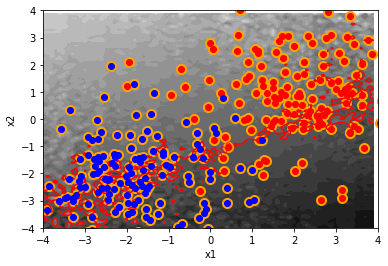

In [15]:
plot_classif(X, y, mu_support, idx_support, b)
plt.scatter(X[idx_support][:,0],X[idx_support][:,1],label="support", color = 'orange', s =100)

In practice it is very likely that the classes are not linearly separable.

A very natural idea is to relax the constraints $y_{i}(w^\top x_i + c) \geq 1$.
To do this, so called soft-margin SVM have been introduced using
so called slack variables: $\xi_{i}\geq 0$. The problem becomes:

$$
 y_{i}(w^\top x_i + b) \geq 1 - \xi_i, \; \xi_i \geq 0 \enspace .
$$

Note that if $\xi_i > 1$, the sample $x_{i}$ will be misclassified. To prevent
this case to be too frequent, an idea is to minimize the sum of the $\xi_{i}$.
This leads to the following problem:

$$
(P_{s}):  \left\{
 \begin{array}{ll}
 \min_{(w,b,\xi)} & \frac{1}{2}w^{\top}w + C \sum_i \xi_i
 \\
 \mathrm{s.t.} & y_{i}(w^{\top}x_{i}+b) \geq 1 - \xi_i\\
 \mathrm{and} & -\xi_i \leq 0
 \end{array}
 \right.
$$

The constant $C$ controls the regularisation.

<div class="alert alert-success">
    <b>QUESTION 9:</b>
     <ul>
         <li>Justify that $(P_{s})$ is a convex problem.</li>
         <li>Show that a dual problem of $(P_{s})$ reads:

$$
(\mathcal{D}):
\left\{
\begin{array}{lll}
\min_{\mu} &\frac{1}{2}\mu^{\top}GG^{\top}\mu-\mu^{\top}u
\\
\mathrm{s.t.}& y^{\top}\mu = 0
\\
\mathrm{et}& 0 \leq \mu \leq C
\end{array}
\right .
$$
         </li>
    </ul>
</div>

<div class="alert alert-warning">
<b>ANSWER QUESTION 9:</b>

(a) $\frac{1}{2}w^Tw$ is a quadratic which is a convex function and $C\sum_i \xi_i = C \xi u$ is a linear function which is convex.
    
$u = (1, \dots, 1) \in \mathbb{R}^n$.

The constraints for $w, b, \xi$ is linear. So the problem is convex.

(b) The lagrange of (P):
$$L(w,b,\mu,v)=\frac{1}{2}w^Tw+\sum_{i=1}^{n}\mu_i(1-\xi_i-y_i(w^Tx_i+b))+\sum_{i=1}^{n}v_i(-\xi_i)+C\sum_{i=1}^{n}\xi_i$$
    
KKT condition:

$$
 \left\{
 \begin{array}{cll}
 w+\sum_{i=1}^{n}\mu_i(-y_ix_i)=0\\
 \sum_{i=1}^{n}\mu_iy_i=0\\
 C-\mu_i-v_i=0\\
 u>0\\
 v>0
 \end{array}
 \right. 
$$    
So (D) can be written as follow condition according to Q2):
$$\min_{u>0, v>0,y^Tu=0}\frac{1}{2}\mu^TGG^T\mu-\mu^Tu +C\sum_{i=1}^{n}\xi_i - \sum_{i=1}^{n}(\mu_i+v_i)\xi_i$$
The last 2 sums = 0 and $u>0, v>0, C=U+V$
    
So $\mu_i<C, i =1,...,n$
$\Longrightarrow$
$$
(\mathcal{D}):
\left\{
\begin{array}{lll}
\min_{\mu} &\frac{1}{2}\mu^{\top}GG^{\top}\mu-\mu^{\top}u
\\
\mathrm{s.t.}& y^{\top}\mu = 0
\\
\mathrm{et}& 0 \leq \mu \leq C
\end{array}
\right .
$$  

<div class="alert alert-success">
    <b>QUESTION 10:</b>
     <ul>
       <li>Modify your code from Question 4 to handle the non-separable case.</li>
    </ul>
</div>

C = 0.01
Number of support vectors: 95


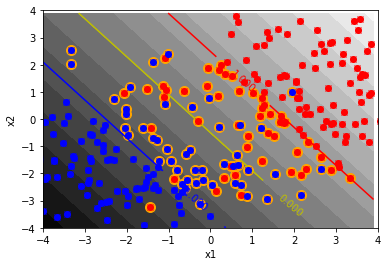

C = 0.1
Number of support vectors: 62


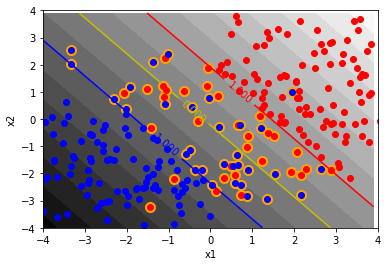

C = 1
Number of support vectors: 57


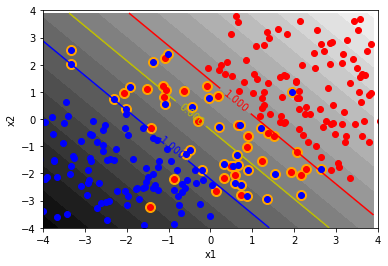

C = 10
Number of support vectors: 57


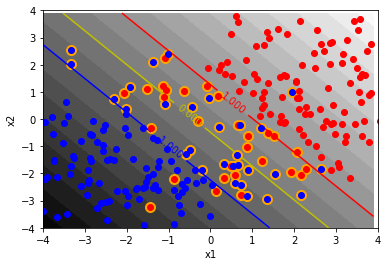

C = 100
Number of support vectors: 81


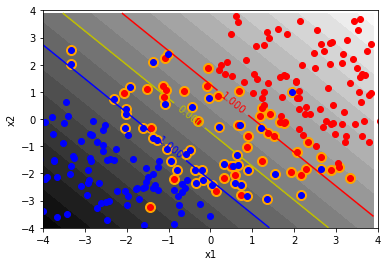

C = 1000
Number of support vectors: 290


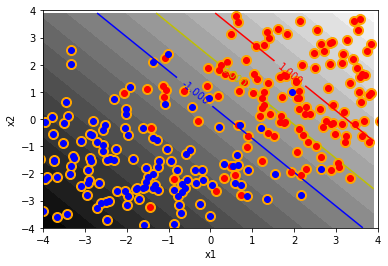

In [16]:
# TODO
def b_non_separable(K, y, mu_support, idx_support, C):
    mu = np.zeros(K.shape[0])
    mu[idx_support] = mu_support 
    i = idx_support[np.where(C - mu_support > 1e-5)[0][0]]
    y_i = y[i] 
    b = y_i - np.sum((y[idx_support] * mu_support) * K[i, idx_support], axis = 0)
    return b

X, y = datasets(name='gaussian', n_points=300, sigma=1.7)
plot_dataset(X, y)
K = kernel(X, X)
C =[0.01, 0.1, 1, 10, 100,1000]
for i in C:
    mu_support, idx_support = svm_solver(K, y, i)
    print("C =", i)
    print("Number of support vectors: %s" % idx_support.size)
    b = b_non_separable(K, y, mu_support, idx_support, i)
    plot_classif(X, y, mu_support, idx_support, b)
    plt.scatter(X[idx_support][:,0],X[idx_support][:,1],label="support", color = 'orange', s =100)
    plt.show()

<div class="alert alert-success">
    <b>QUESTION 11:</b>
     <ul>
       <li>What is the influence of C on the number of support vectors? Make a plot that demonstrates this empirically.</li>
    </ul>
</div>

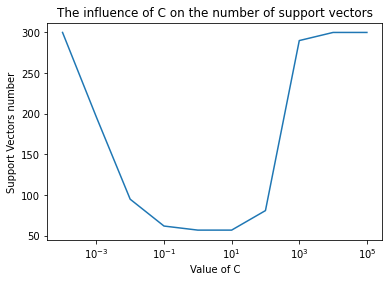

In [17]:
C = [1e-4,1e-3,1e-2,1e-1,1,10,100,1000,1e4,1e5]
supp_vect=[]
for i in C:
    mu_support, idx_support = svm_solver(K, y, C=i)
    supp_vect.append(idx_support.shape[0])
plt.title('The influence of C on the number of support vectors')
plt.xlabel('Value of C')
plt.ylabel('Support Vectors number')
plt.xscale('log')
plt.plot(C,supp_vect)

The value of C influences the number of support vectors such that if C is too small or too high, the number of support vectors is high. On a certain interval, the smaller the value of C, the greater the number of vector supports. Indeed, if C is too low, the regularization is strong, and the allowed margin is large. If C is too large, we have a high penalty for nonseparable points and we may store many support vectors and overfit. Therefore, we have to find the good trade-off.

<div class="alert alert-info">
    <h2>Part 3: non-linear case with kernels</h2>
</div>

Another scenario is when the boundary between classes is not linear.

To cope with this the idea is to use kernels.

<div class="alert alert-success">
    <b>QUESTION 12:</b>
     <ul>
       <li>Denoting by $K(x_i, x_j)$ the dot product between samples, show that dual problem and the decision function f(x) can be reformulated just using calls to $K$</li>
    </ul>
</div> 

<div class="alert alert-warning">
<b>ANSWER QUESTION 12:</b>

$$K(x_i, x_j)=x_i^Tx_j \quad K = \begin{pmatrix}
x_1^Tx_1 & x_1^Tx_2 &\cdots & x_1^Tx_n\\
\vdots & & & \vdots\\
x_n^Tx_1 & \cdots & \cdots & x_n^Tx_n
\end{pmatrix}$$

$$G=\begin{pmatrix}y_1x_1^T\\ \vdots\\ y_nx_n^T \end{pmatrix} \quad GG^T = \begin{pmatrix}
x_1^Tx_1y_1y_1 &\cdots & x_1^Tx_ny_1y_n\\
\vdots & & \vdots\\
x_n^Tx_1y_ny_1 & \cdots  & x_n^Tx_ny_ny_n
\end{pmatrix}$$    
    
$$GG^T=(K^T\cdot diag(y))^T\cdot diag(y)$$

$$
(\mathcal{D}):
\left\{
\begin{array}{lll}
\min_{\mu} &\frac{1}{2}\mu^{\top}((K^T\cdot diag(y))^T\cdot diag(y))\mu-\mu^{\top}u
\\ 
\mathrm{s.t.}& y^{\top}\mu = 0
\\
\mathrm{et}& 0 \leq \mu \leq C
\end{array}
\right .
$$  
Decision function:
$$f(x)=sign(w^Tx+b)=sign(\sum_{i=1}^{n}\mu_iy_ix_i^Tx+b)=sign(\sum_{i=1}^{n}\mu_iy_iK(x_i,x)+b)$$
and $$b=y_j-\sum_{i=1}^{n}\mu_iy_iK(x_i,x_j)$$, j is an arbitrary support vector.
   
</div>

We will use the clowns dataset to evaluate this:

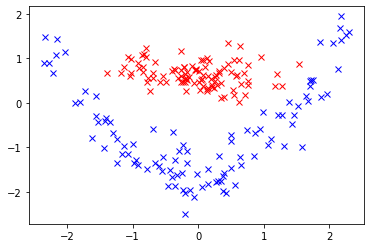

In [18]:
X, y = datasets(name='clowns', n_points=200, sigma=0.7)

plot_dataset(X, y)

<div class="alert alert-success">
    <b>QUESTION 13:</b>
     <ul>
       <li>Update your kernel function so it computes the Gaussian kernel:</li>
    </ul>
    $$
    K(x_i, x_j) = \exp(-\gamma \| x_i - x_j \|^2)
$$

where $\gamma > 0$ is the kernel bandwidth.
</div> 

In [19]:
# TODO

from scipy import linalg

def rbf_kernel(X1, X2):
    n1 = X1.shape[0]
    n2 = X2.shape[0]
    K = np.empty((n1, n2))
    gamma = 3.
    # TO DO
    for i in range(n1):
        for j in range(n2):
            K[i][j]=np.exp(-gamma*linalg.norm(X1[i,:]-X2[j,:]))
    return K

Using the change above the follwing code should allow you to nicely separate the red from the blue dots

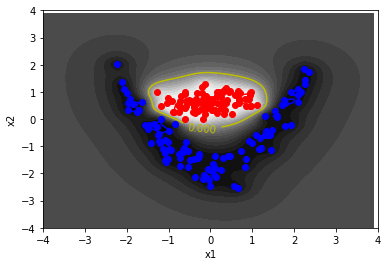

In [20]:
X, y = datasets(name='clowns', n_points=200, sigma=0.7)

K = rbf_kernel(X, X)
mu_support, idx_support = svm_solver(K, y, C=1.)
b = compute_b(K, y, mu_support, idx_support)

plot_classif(X, y, mu_support, idx_support, b, kernel=rbf_kernel)

<div class="alert alert-info">
    <h2>Part 4: Linear SVM without intercept</h2>
</div>

The problem of the formuation of SVMs with the intercept term $b$ is that
it leads to an annoying constraint in the dual, namely the $y^\top \mu = 0$.

We will now see what we can do about it.

Let's consider the problem

$$
(P'_{s}):  \left\{
 \begin{array}{ll}
 \min_{(w,\xi)} & \frac{1}{2}w^{\top}w + C \sum_i \xi_i
 \\
 \mathrm{s.t.} & y_{i}(w^{\top}x_{i}) \geq 1 - \xi_i\\
 \mathrm{and} & -\xi_i \leq 0
 \end{array}
 \right.
$$

<div class="alert alert-success">
    <b>QUESTION 14:</b>
     <ul>
       <li>Show that a dual problem of $(P'_{s})$ is given by:

$$
(\mathcal{D}):
\left\{
\begin{array}{lll}
\min_{\mu} &\frac{1}{2}\mu^{\top}GG^{\top}\mu-\mu^{\top} 1_n
\\
\mathrm{s.t.}& 0 \leq \mu \leq C
\end{array}
\right .
$$
         </li>
    </ul>
</div> 

<div class="alert alert-warning">
<b>ANSWER QUESTION 14:</b>
$$L(w,b,\mu, v) = \frac{1}{2}w^Tw + \sum_{i=1}^{n}\mu_i(1-\xi_i-y_iw^Tx_i)+\sum_{i=1}^{n}v_i(-\xi_i)$$
    
KKT condition:

$$
 \left\{
 \begin{array}{1ll}
 w+\sum_{i=1}^{n}\mu_i(-y_ix_i)=0\\
 C = u_i+v_i, i=1,...,n\\
 u>0\\
 v>0
 \end{array}
 \right. 
$$        
(D) can be written as follows:    

$$
 \left\{
 \begin{array}{lll}
 \min_{u}\frac{1}{2}\mu^TGG^T\mu-\mu^T1_n\\
 \mathrm{s.t.}\quad 0 \leq \mu \leq C\\
 \end{array}
 \right. 
$$  
    
    
</div>

<div class="alert alert-success">
    <b>QUESTION 15:</b>
     <ul>
       <li>Rewrite the dual in the form:


$$
(\mathcal{D}): \min_{\mu} f(\mu) + g(\mu) .
$$

where $f$ is here a smooth function of $\mu$ with L-Liptschitz gradient and $g$ is a non-smooth function that is separable, namely:

$$
g(\mu) = \sum_{i=1}^n g_i(\mu_i)
$$
         </li>
    </ul>
</div>

<div class="alert alert-warning">
<b>ANSWER QUESTION 15:</b>
$$
 \left\{
 \begin{array}{lll}
 \min_{u}\frac{1}{2}\mu^TGG^T\mu-\mu^T1_n\\
 \mathrm{s.t.}\quad 0 \leq \mu \leq C\\
 \end{array}
 \right. 
$$     
$$f(\mu)=\frac{1}{2}\mu^TGG^T\mu-\mu^T1_n$$
$$g(\mu)=l_{0<\mu<c}(\mu) = \sum_{i=1}^{n}l_{0<\mu<c}g_i(\mu_i)$$ $$\nabla f(\mu)=GG^T\mu - \mathbb {1}_n$$ 
$$||\nabla f(x)-\nabla f(y)||_2=||GG^T(x-y)||_2 \leq \delta_{max} (GG^T)||x-y||$$
So $f(\mu)$ is $\delta_{max}(GG^T)$ - lipshitz smooth, $g(\mu)$ is non-smooth function.
    
    
    
</div>

The dual in the later form can be readily optimized using the methods that you have been studying in this class:

- Proximal gradient method with and without acceleration
- L-BFGS-B
- Coordinate descent

<div class="alert alert-success">
    <b>QUESTION 16:</b>
     Implement:
     <ul>
       <li>your own version of proximal gradient with and without acceleration</li>
       <li>your own version of coordinate descent</li>
       <li>an L-BFGS-B solver using `scipy.optimize.fmin_l_bfgs_b`</li>
    </ul>
    Test your implementations on the Gaussian blobs and evaluate the performance
    of your implementations in terms of computation time on problems where the matrix 
    $G G^\top$ can fit in memory. Give a short conclusion.
</div>

Note: We restrict ourselves to linear kernel here.

Note: To handle separating hyperplanes which do not pass throw zero (due to abscence of intercept)
you will add a column of ones to X. You can use something like this:

`X = np.concatenate((X, np.ones((len(X), 1))), axis=1)`

You should reuse as much as possible the convergence evaluation code that you used during the labs.

For a coordinate descent method to be fast you need to have smart updates. You're expected to
come up with these smart updates in the problem at hand.

BONUS : With a smart implementation of the coordinate descent you should be able to scale the optimization to tens of thousands of samples ie cases where $G G^\top$ does not fit in memory anymore.

**IMPORTANT : This question Q16 is voluntary vague, but it is the most important and will constitute half of the final grade on the project ! We are waiting for beautiful plots, as well as sharp comments!**

In [513]:
X, y = datasets(name='gaussian', n_points=300, sigma=1.5)
X = np.concatenate((X, np.ones((len(X), 1))), axis=1)

### At first we use the QP solver to calculate the true minimal.

In [514]:
def QP(H, e, C=np.inf, l=1e-8, verbose=True):
    # Gram matrix
    n = H.shape[0]
    H = cvxopt.matrix(H)
    e = cvxopt.matrix(-e)
    if C == np.inf:
        G = cvxopt.matrix(np.diag(np.ones(n) * -1))
        h = cvxopt.matrix(np.zeros(n))
    else:
        G = cvxopt.matrix(np.concatenate([np.diag(np.ones(n) * -1),
                                         np.diag(np.ones(n))], axis=0))
        h = cvxopt.matrix(np.concatenate([np.zeros(n), C * np.ones(n)]))

    # Solve QP problem
    cvxopt.solvers.options['show_progress'] = verbose
    solution = cvxopt.solvers.qp(H, e, G, h)
 
    # Lagrange multipliers
    mu = np.ravel(solution['x'])
    return mu


def kernel(X1, X2):
    n1 = X1.shape[0]
    n2 = X2.shape[0]
    K = np.empty((n1, n2))
    for i in range(n1):
        for j in range(n2):
            K[i, j] = np.dot(X1[i], X2[j])
    return K


def svm_solver(K, y, C=np.inf):
    H = ((y * K).T*y).T
    e = np.ones(y.shape[0])
    mu = QP(H, e, C, l=1e-8, verbose=False)
    idx_support = np.where(np.abs(mu) > 1e-5)[0]
    mu_support = mu[idx_support]
    return mu, mu_support, idx_support

# we assume this mu is the best mu

In [515]:
K = kernel(X,X)
c = 0.5
mu,_,_= svm_solver(K, y,c)

In [516]:
from scipy.linalg import norm
from scipy.optimize import fmin_l_bfgs_b

class Svm():
    def __init__(self, X, y, C, n_iter):
        self.X = X
        self.y = y
        self.C = C
        K = kernel(X, X)
        self.H = ((y * K).T*y).T
        self.n = y.shape[0]
        self.e = np.ones(self.n)
        self.n_iter = n_iter
    
    def f_g(self,u):
        return (u.T.dot(self.H.dot(u)))/2 - u.dot(np.ones_like(u)) + indicator(u,self.C)
    
    def indicator(self,u):
        """ Indicator function """
        if np.any(u < 0):
            return np.inf
        if np.any(u > self.C):
            return np.inf
        return 0

    def lipschitz_constant(self):
        """ largest singular value """
        return norm(self.H, ord=2)
    
    def prox(self,x):
        """ projection on [0, C] :min(x, C) or max(0, x) = max(0,min(x, C)) = min(max(0, x),C) """
        p = x.copy()
        p[x > self.C] = self.C
        p[x < 0] = 0
        return p
    
    def prox_i(self,x):
        """ projection on [0, C] :min(x, C) or max(0, x) = max(0,min(x, C)) = min(max(0, x),C) """
        p = x
        if x > self.C:
            p = self.C
        if x < 0:
            p = 0
        return p
    
    def grad(self,x):
        return self.H.dot(x) - self.e
    
    def ista(self):
        u = np.zeros(n)
        step = 1/self.lipschitz_constant()
        U = []
        for _ in range(self.n_iter):
            u = self.prox(u - step * self.grad(u))
            U.append(u)
        return u,U
    
    def fista(self):
        u = np.zeros(n)
        z = np.zeros(n)
        beta = 1.
        step = 1/self.lipschitz_constant()
        U = []
        for _ in range(n_iter):
            u_ = self.prox(z - step * self.grad(u))
            beta_ = (1. + np.sqrt(1 + 4 * beta**2))/ 2
            z = u_ + (beta - 1) / beta_ * (u_ - u)
            u = u_
            beta = beta_
            U.append(u)
        return u,U  

In [517]:
c = 0.5
n_iter = 3000
svm = Svm(X,y,c,n_iter)
mu_ista,Mu_ista = svm.ista()
mu_fista,Mu_fista = svm.fista()

In [518]:
class Svm_cd():
    def __init__(self, X, y, C, n_iter):
        self.X = X
        self.y = y
        self.C = C
        self.n = y.shape[0]
        self.e = np.ones(self.n)
        self.n_iter = n_iter
    
    def grad_i(self, w, i):
        return self.y[i] * np.dot(w, X[i, :]) - 1
    
    def indicator(self,u):
        """ Indicator function """
        if np.any(u < 0):
            return np.inf
        if np.any(u > self.C):
            return np.inf
        return 0
    
    def prox(self,x):
        """ projection on [0, C] :min(x, C) or max(0, x) = max(0,min(x, C)) = min(max(0, x),C) """

        x_ = x.copy()
        if x > self.C:
            x_ = self.C
        if x < 0:
            x_ = 0
        return x_
    
    
    def lipschitz_i(self):
        K = kernel(X, X)
        H = ((y * K).T*y).T
        return np.diagonal(H)
    
    
    def get_w(self, x):
        return np.sum( (self.y * x)[:, None] * self.X, axis=0)
    
    def update_w(self, x_i_old, x_i, old_w, i):
        return old_w + (x_i - x_i_old) * self.y[i] * self.X[i, :]
    
    def cd(self):
        x = np.zeros(self.n)
        w = self.get_w(x)
        step = 1/self.lipschitz_i()
        U = []
        for k in range(n_iter):
            i = k % n
            xi_old = x[i]
            grad_i = self.grad_i(w, i)
            x[i] = self.prox(x[i] - step[i] * grad_i)
            w = self.update_w(xi_old, x[i], w, i)
            U.append(x)
        return x,U
    
    def loss(self, u):
        return 1. / 2 * u.dot(self.H.dot(u)) - u.dot(self.e) + self.indicator(u)

In [590]:
from scipy.optimize import fmin_l_bfgs_b


def grad(u,H,e,C):
    return H.dot(u) - e
    
    
def loss(u,H,e,C):
    return 1. / 2 * u.dot(H.dot(u)) - u.dot(e) + indicator(u,C)

def indicator(u,C):
    
    if np.any(u < 0):
        return np.inf
    if np.any(u > C):
        return np.inf
    return 0

def prox(x,C):
    p = x.copy()
    p[x >C] =C
    p[x < 0] = 0
    return p

class Svm_bfgs():
    def __init__(self, X, y, C):
        self.X = X
        self.y = y
        self.C = C
        self.n = y.shape[0]
    
    def bfgs(self):
        bounds = [(0, c) for i in range(self.n)]
        u_init = np.zeros(n)
        K = kernel(X, X)
        H = ((self.y * K).T*self.y).T
        e = np.ones(self.n)
        mu,,_ =  fmin_l_bfgs_b(loss,u_init,grad,args=(H,e,self.C),factr=10.,bounds=bounds)
        return mu

In [591]:
c = 0.5
svm1 = Svm_cd(X,y,c,n_iter)
mu_cd ,Mu_cd= svm1.cd()

In [593]:
svm2 = Svm_bfgs(X,y,c)
mu_bfgs = svm2.bfgs()

In [361]:
Distance_ista = []
Distance_fista = []
for i in range(len(Mu_ista)):
    Distance_ista.append(norm(Mu_ista[i]-mu)/mu.shape[0])
    Distance_fista.append(norm(Mu_fista[i]-mu)/mu.shape[0])

In [362]:
Distance_cd = []
for i in range(len(Mu_cd)):
    Distance_cd.append(norm(Mu_cd[i]-mu)/mu.shape[0])

In [562]:
Distance_bfgs = norm(mu_bfgs-mu)/mu.shape[0]
print(Distance_bfgs)

0.010920465723934262


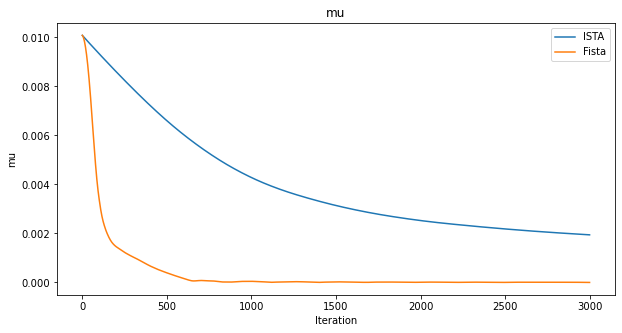

In [363]:
plt.figure(figsize=(10,5))
plt.plot(Distance_ista,label="ISTA")
plt.plot( Distance_fista,label="Fista")
plt.title('mu')
plt.xlabel('Iteration')
plt.ylabel('mu')
plt.legend()
plt.show()

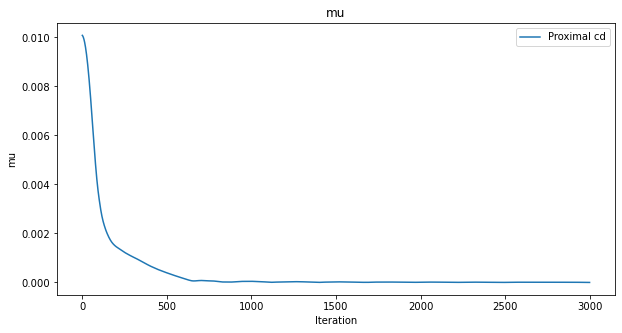

In [364]:
plt.figure(figsize=(10,5))
plt.plot( Distance_fista,label="Proximal cd")
plt.title('mu')
plt.xlabel('Iteration')
plt.ylabel('mu')
plt.legend()
plt.show()

In [534]:
def get_support_vec(mu):
    idx_support = np.where(np.abs(mu) > 1e-5)[0]
    mu_support = mu[idx_support]
    return mu_support, idx_support

def compute_w_b(mu, y, X):
    mu_support, idx_support = get_support_vec(mu)
    w = np.sum((mu_support * y[idx_support])[: , None] * X[idx_support], axis=0)
    return w[:-1], w[2]

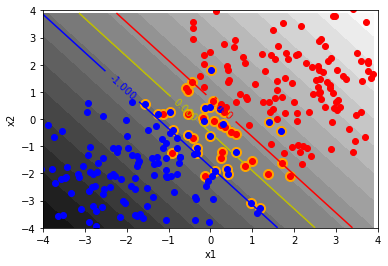

In [536]:
mu_support, idx_support = get_support_vec(mu)
_, b = compute_w_b(mu, y, X)
K = kernel(X,X)
plot_classif(X[:, :-1], y, mu_support, idx_support, b)
plt.scatter(X[idx_support][:,0],X[idx_support][:,1],label="support", color = 'orange', s =100)

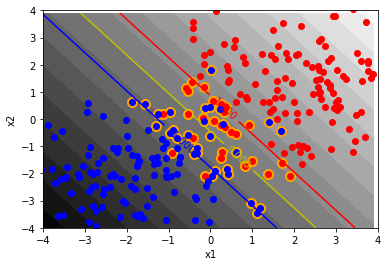

In [537]:
mu_support, idx_support = get_support_vec(mu_ista)
_, b = compute_w_b(mu_ista, y, X)
K = kernel(X,X)
plot_classif(X[:, :-1], y, mu_support, idx_support, b)
plt.scatter(X[idx_support][:,0],X[idx_support][:,1],label="support", color = 'orange', s =100)

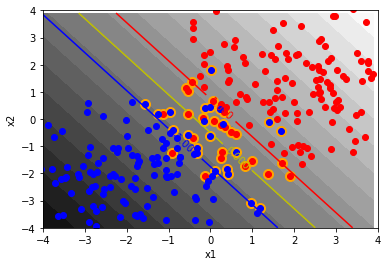

In [538]:
mu_support, idx_support = get_support_vec(mu_fista)
_, b = compute_w_b(mu_fista, y, X)
K = kernel(X,X)
plot_classif(X[:, :-1], y, mu_support, idx_support, b)
plt.scatter(X[idx_support][:,0],X[idx_support][:,1],label="support", color = 'orange', s =100)

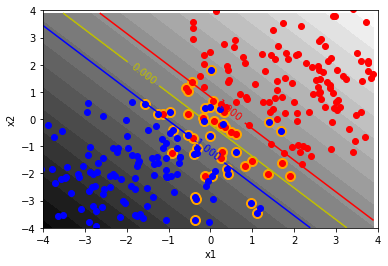

In [539]:
mu_support, idx_support = get_support_vec(mu_cd)
_, b = compute_w_b(mu_cd, y, X)
K = kernel(X,X)
plot_classif(X[:, :-1], y, mu_support, idx_support, b)
plt.scatter(X[idx_support][:,0],X[idx_support][:,1],label="support", color = 'orange', s =100)

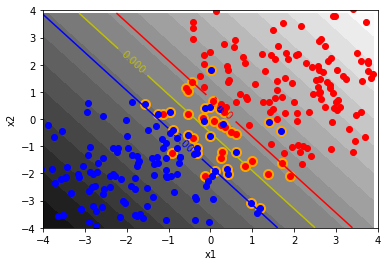

In [594]:
mu_support, idx_support = get_support_vec(mu_bfgs)
_, b = compute_w_b(mu_bfgs, y, X)
K = kernel(X,X)
plot_classif(X[:, :-1], y, mu_support, idx_support, b)
plt.scatter(X[idx_support][:,0],X[idx_support][:,1],label="support", color = 'orange', s =100)

<div class="alert alert-info">
    <h2>Part 5: SVM Rank</h2>
</div>

You will now use the code you have written above to answer the following question: given two samples $x_i$ and $x_j$ in $\mathbb{R}^p$, with corresping labels $y_i$ and $y_j$ in $\mathbb{R}$ (note that now labels can be any real number, it's not just binary). Can I predict if $y_i > y_j$ or the oppositve?

To take a concrete example, imaging you go to a liquor store to buy a bottle on wine and you hesitate between two bottles. The SVM Rank model below will tell you if the quality of the wine encoded in the target $y$ is better for the first bottle or the second one.

Let's formalize this a bit. We aim to estimate a linear function $f_{w}(x) = x^\top w$ that minimizes
the following risk:

$$
\mathcal{R}_f=\mathbb{E}
    \left[
    \ell(f_w(x_i) - f_w(x_j), \mathrm{sign}(y_i-y_j))
    \right]
$$

where the loss $\ell$ is the Hinge loss of the SVM binary classifical model you have seen above. Namely:
$
    \ell(z, t) = \max(1 - tz, 0)
$ . Note that we limit ourselves here to linear SVM.

This leads to the following regularized empirical risk minimization problem:

$$
\hat{w} = \mathrm{arg}\,\min_{w \in \mathbb{R}^p} \left( C \sum_{i,j} \ell((x_i - x_j)^\top w, \mathrm{sign}(y_i-y_j)) + \|w\|_2^2 \right),
$$


This part is inspired by the following works:

    - R. Herbrich, T. Graepel, and K. Obermayer. Large margin rank boundaries for ordinal regression. MIT Press, Cambridge, MA, 2000.

    - T. Joachims. Optimizing search engines using clickthrough data. In Proceedings of the eighth ACM SIGKDD international conference on Knowledge discovery and data mining, pages 133–142, New York, NY, USA, 2002. ACM. 2
    
The following cell implements the `transform_pairwise` function. Given `X` and `y` this function builds all the pairs of samples to output a new dataset that corresponds to a binary classification problem. It basically outputs the differences between feature vectors and the sign of the difference of the targets.

In [595]:
import itertools


def transform_pairwise(X, y):
    """Transforms data into pairs with balanced labels for ranking

    Transforms a n-class ranking problem into a two-class classification
    problem.

    In this method, all pairs are choosen, except for those that have the
    same target value. The output is an array of balanced classes, i.e.
    there are the same number of -1 as +1

    Parameters
    ----------
    X : array, shape (n_samples, n_features)
        The data
    y : array, shape (n_samples,)
        Target labels.

    Returns
    -------
    X_trans : array, shape (n_pairs, n_features)
        Data formed by difference of feature vectors.
    y_trans : array, shape (n_pairs,)
        Output class labels, where classes have values {-1, +1}
    """
    X_new = []
    y_new = []
    comb = itertools.combinations(range(X.shape[0]), 2)
    k = 0
    for (i, j) in comb:
        if y[i] == y[j]:
            # skip if same target or different group
            continue
        X_new.append(X[i] - X[j])
        y_new.append(np.sign(y[i] - y[j]))
        # output balanced classes
        if y_new[-1] != (-1) ** k:
            y_new[-1] = - y_new[-1]
            X_new[-1] = - X_new[-1]
        k += 1
    return np.array(X_new), np.array(y_new)

<div class="alert alert-success">
    <b>QUESTION 17:</b>
     The following cell implements a scikit-learn estimator for the SVM Rank
     model. It uses the liblinear solver shipped with scikit-learn.
     <ul>
       <li>Update the following code to use a solver developed above instead of scikit-learn LinearSVC estimator.
         You will justify this choice of solver in terms of performance
         based your experiments above.</li>
       <li>Run your updated estimator on the Wine quality dataset
         and compare the performance of your model with the liblinear
         solver. You will compare in terms of prediction score
         and in terms of computation time.</li>
    </ul>
</div>

**Note:** For the scorer we use here the [Kendall's rank correlation](https://en.wikipedia.org/wiki/Kendall_rank_correlation_coefficient)

$$
    \tau ={\frac {2}{n(n-1)}}\sum _{i<j}\operatorname {sgn}(x_{i}-x_{j})\operatorname {sgn}(y_{i}-y_{j})
$$

implemented in `scipy.stats.kendalltau`.

In [596]:
from scipy import stats
from sklearn import svm
from sklearn.base import BaseEstimator, RegressorMixin


class RankSVM(BaseEstimator, RegressorMixin):
    """Performs pairwise ranking with an underlying linear SVM model

    Input should be a n-class ranking problem, this object will convert it
    into a two-class classification problem, a setting known as
    `pairwise ranking`.
    """
    def __init__(self, C=1.0):
        self.C = C

    def fit(self, X, y):
        """Fit a pairwise ranking model.

        Parameters
        ----------
        X : array, shape (n_samples, n_features)
        y : array, shape (n_samples,)

        Returns
        -------
        self
        """
        self.svc_ = svm.LinearSVC(loss='hinge', dual=True, tol=1e-2,
            fit_intercept=True, C=self.C, max_iter=1000000)
        X_trans, y_trans = transform_pairwise(X, y)
        self.svc_.fit(X_trans, y_trans)
        return self

    def predict(self, X):
        """
        Predict an ordering on X. For a list of n samples, this method
        returns a list from 0 to n-1 with the relative order of the rows of X.

        Parameters
        ----------
        X : array, shape (n_samples, n_features)

        Returns
        -------
        ord : array, shape (n_samples,)
            Returns an array of integers representing the relative order of
            the rows in X.
        """
        return np.argsort(np.dot(X, self.svc_.coef_.T).ravel())

    def score(self, X, y):
        """Score using Kendall rank correlation
        
        https://en.wikipedia.org/wiki/Kendall_rank_correlation_coefficient

        Parameters
        ----------
        X : array, shape (n_samples, n_features)
        y : array, shape (n_samples,)

        Returns
        -------
        score : float
            Kendall Tau rank correlation. Higher is better.
        """
        return stats.kendalltau(self.predict(X), y)[0]

In [597]:
# Loading the data
import pandas as pd
from sklearn.model_selection import cross_val_score

df = pd.read_csv('winequality-red.csv', delimiter=';')
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [598]:
%%time

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

df_small = df[::2]  # take a smaller dataset to speed things up
X = df_small.iloc[:, :-1].values

y = df_small.quality.values
clf = make_pipeline(StandardScaler(), RankSVM(C=1.))
scores = cross_val_score(clf, X, y, cv=3)
print("Average Kendall Rank Correlation: %0.2f" % scores.mean())

Average Kendall Rank Correlation: 0.07
Wall time: 8.5 s


In [602]:
class Svm_cd():
    def __init__(self, X, y, C, n_iter):
        self.X = X
        self.y = y
        self.C = C
        self.n = y.shape[0]
        self.e = np.ones(self.n)
        self.n_iter = n_iter
    
    def grad_i(self, w, i):
        return self.y[i] * np.dot(w, X[i, :]) - 1
    
    def indicator(self,u):
        """ Indicator function """
        if np.any(u < 0):
            return np.inf
        if np.any(u > self.C):
            return np.inf
        return 0
    
    def prox(self,x):
        """ projection on [0, C] :min(x, C) or max(0, x) = max(0,min(x, C)) = min(max(0, x),C) """

        x_ = x.copy()
        if x > self.C:
            x_ = self.C
        if x < 0:
            x_ = 0
        return x_
    
    
    def lipschitz_i(self):
        K = kernel(X, X)
        H = ((y * K).T*y).T
        return np.diagonal(H)
    
    
    def get_w(self, x):
        return np.sum( (self.y * x)[:, None] * self.X, axis=0)
    
    def update_w(self, x_i_old, x_i, old_w, i):
        return old_w + (x_i - x_i_old) * self.y[i] * self.X[i, :]
    
    def cd(self):
        x = np.zeros(self.n)
        w = self.get_w(x)
        step = 1/self.lipschitz_i()
        U = []
        for k in range(n_iter):
            i = k % n
            xi_old = x[i]
            grad_i = self.grad_i(w, i)
            x[i] = self.prox(x[i] - step[i] * grad_i)
            w = self.update_w(xi_old, x[i], w, i)
            U.append(x)
        return x,U
    
    def loss(self, u):
        return 1. / 2 * u.dot(self.H.dot(u)) - u.dot(self.e) + self.indicator(u)

In [603]:
from scipy import stats
from sklearn import svm
from sklearn.base import BaseEstimator, RegressorMixin

def get_support_vec(mu):
    idx_support = np.where(np.abs(mu) > 1e-5)[0]
    mu_support = mu[idx_support]
    return mu_support, idx_support

def compute_w_b(mu, y, X):
    mu_support, idx_support = get_support_vec(mu)
    w = np.sum((mu_support * y[idx_support])[: , None] * X[idx_support], axis=0)
    return w

class RankSVM(BaseEstimator, RegressorMixin):

    def __init__(self, C=1.0):
        self.C = C

    def fit(self, X, y):
        X_trans, y_trans = transform_pairwise(X, y)
        svc_ =  Svm_cd(X_trans,y_trans,self.C,100)
        mu,_ = svc_.cd()
        self.mu = mu
        w = compute_w_b(self.mu, y, X)
        self.w = w
        return self

    def predict(self, X):
        return np.argsort((np.dot(X,self.w.T).ravel()))

    def score(self, X, y):
        return stats.kendalltau(self.predict(X), y)[0]

In [604]:
%%time

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

df_small = df[::2]  # take a smaller dataset to speed things up
X = df_small.iloc[:, :-1].values

y = df_small.quality.values
clf = make_pipeline(StandardScaler(), RankSVM(C=1.))
scores = cross_val_score(clf, X, y, cv=3)
print("Average Kendall Rank Correlation: %0.2f" % scores.mean())

Average Kendall Rank Correlation: 0.04
Wall time: 3.84 s


## Comment
- I first used the QP solver to get the true minimum. I then implemented the ISTA and FISTA algorithms and computed the error by substracting the true minimum found with the QP solver.
- As expected from the previous TPs, we get:
    - ISTA presents a linear convergence $O(1/k)$ and is a descent algorithm. 
    - FISTA is much faster and has a $O(1/k^2)$ convergence 
    - Smart coordinate descent allows us to deal with the probelm of size of dataset,oly this algorithm can deal with the memory problem
    - Lbfgs-B gives the best result whithin a low number of iterations.

- All the four algorithms converge and give results with a given precision.